### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
import warnings
warnings.simplefilter("always")

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# Weizmann dataset
from src_weizmann.weizmann import download_weizmann, download_weizmann_masks
from src_weizmann.weizmann import PERSONS, ACTIONS, DESCRIPTIONS

In [15]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [16]:
from tqdm import tqdm

In [17]:
from datetime import datetime

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Diffractive Recurrent Neural Network (D-RNN)

In that notebook we load weights for a recurrent diffractive network [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4) for [the Weizmann dataset](https://www.wisdom.weizmann.ac.il/~vision/SpaceTimeActions.html) trained in `07_weizmann_drnn.ipynb`.

In [19]:
# list of all saved models
dir_models = 'models/reproduced_results'

filepathes = []

for file in os.listdir(dir_models):      
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

.DS_Store
Fashion-MNIST_Ozcan_2018-2020
MNIST_MSE_Ozcan_2018-2020
MNIST_Ozcan_2018-2020
weizmann
weizmann_accuracy-86
weizmann_exp_26-02-2025_02-54
weizmann_exp_27-02-2025_01-53
weizmann_exp_28-02-2025_16-42


In [20]:
RESULTS_FOLDER = f'{dir_models}/weizmann_accuracy-86'  # SELECTING AN EXPERIMENT
RESULTS_FOLDER

'models/reproduced_results/weizmann_accuracy-86'

In [21]:
# OR read conditions from file:
with open(f'{RESULTS_FOLDER}/conditions.json') as json_file:
    VARIABLES = json.load(json_file)

VARIABLES

{'data_path': 'data/weizmann',
 'results_path': 'models/reproduced_results/weizmann_exp_26-02-2025_02-54',
 'wavelength': 0.00075,
 'neuron_size': 0.00039999999999999996,
 'mesh_size': [400, 400],
 'use_apertures': True,
 'aperture_size': [200, 200],
 'sequence_len': 3,
 'skip_between_frames': 2,
 'modulation': 'amp',
 'augmentation_flip': True,
 'center_silhouettes': True,
 'exclude_cutted_silhouettes': True,
 'detector_segment_size': 0.009,
 'fusing_coefficient': 0.2,
 'max_phase': 6.283185307179586,
 'init_phase': 3.141592653589793,
 'free_space_method': 'AS',
 'free_space_distance': 0.09,
 'read_in_freespace': True,
 'use_nonlinear_layers': [False, False, False],
 'weighted_detector_zones': True,
 'loss': 'CE',
 'calculate_accuracies': True,
 'DEVICE': 'cpu',
 'train_batch_size': 10,
 'val_batch_size': 20,
 'adam_lr': 0.01,
 'number_of_epochs': 15}

# 1. Simulation parameters

In [22]:
working_wavelength = VARIABLES['wavelength']  # [m] - like for MNIST

c_const = 299_792_458  # [m / s]
working_frequency = c_const / working_wavelength # [Hz]

In [23]:
print(f'lambda    = {working_wavelength * 1e9:.3f} nm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 750000.000 nm
frequency = 0.400 THz


In [24]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']  # [m] - like for MNIST
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 400.000 um


In [25]:
APERTURES = VARIABLES['use_apertures']  # add apertures BEFORE each diffractive layer or not

In [26]:
LAYER_SIZE = VARIABLES['mesh_size']  # mesh size
DETECTOR_SIZE = VARIABLES['aperture_size']

In [27]:
# number of neurons in simulation
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 400 x 400 = 160000


In [28]:
# physical size of each layer
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 160.000 x 160.000


In [29]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation

<span style="color:red">**Comment:**</span> Data is already loaded!

In [30]:
WEIZMANN_DIR = VARIABLES['data_path']

#### Load masks (if not loaded yet)

In [31]:
# uncomment to download masks if not loaded:
# download_weizmann_masks(dest=WEIZMANN_DIR)

#### Actions labels

In [30]:
NUM_ACTIONS = len(ACTIONS)

In [31]:
with open(f'{RESULTS_FOLDER}/id2action.json') as json_file:
    ID_TO_ACTION = json.load(json_file)

ID_TO_ACTION = {int(idx): act for idx, act in ID_TO_ACTION.items()}
ID_TO_ACTION

{0: 'bend',
 1: 'jack',
 2: 'jump',
 3: 'pjump',
 4: 'run',
 5: 'side',
 6: 'skip',
 7: 'walk',
 8: 'wave1',
 9: 'wave2'}

In [32]:
ACTION_TO_ID = {act: idx for idx, act in ID_TO_ACTION.items()}
ACTION_TO_ID

{'bend': 0,
 'jack': 1,
 'jump': 2,
 'pjump': 3,
 'run': 4,
 'side': 5,
 'skip': 6,
 'walk': 7,
 'wave1': 8,
 'wave2': 9}

## 2.1. Train and Test data 

In [33]:
# list of train files
all_train_files = []

with open(f'{RESULTS_FOLDER}/train_files.txt') as file:
    all_train_files = [line.rstrip('\n') for line in file]

In [34]:
# list of test files
all_test_files = []

with open(f'{RESULTS_FOLDER}/test_files.txt') as file:
    all_test_files = [line.rstrip('\n') for line in file]

In [35]:
print(f'Train files: {len(all_train_files)}')
print(f'Test  files: {len(all_test_files)}')

Train files: 60
Test  files: 30


## 2.2. Data sequencing 

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> ... each video was divided into numbers of sub-sequences by sequentially extracting three frames for each sub-sequence with a frame interval of two.

In [36]:
NETWORK_SEQ = VARIABLES['sequence_len']
SKIP = VARIABLES['skip_between_frames']  # it is a skip between timesteps in sequences

## 2.3. Dataset construction

In [37]:
INIT_MASK_SIZE = 64  # each loaded mask is of the shape 64x64

#### Centering of silhouettes

In [38]:
# we can center each silhouette before forming a subsequence!
CENTERING = VARIABLES['center_silhouettes']

# for silhouette detection (needed if CENTERING == True)
BRIGHTNESS_LIM = 0.05  # value from 0 to 1 to build strickt boundaries of a silhouette
CENTERED_MASK_SIZE = INIT_MASK_SIZE
# We add 0's padding to a silhouette rectangle to make a square of the following size!
# Comment: An approximate height (absolute) of each silhouette is 30 (?)

#### Exclude cutted (incomplete) silhouettes

In [39]:
EXCLUDE_CUTTED = VARIABLES['exclude_cutted_silhouettes']
# Comment: Some frames are cutted because for some actions a person appears within 
#          a frame and goes to the opposite boundary! 

# Criterias to exclude a frame because of a part of a silhouette is out of frame:
# 1. one of boundaries of a silhouette bounding box coincides with a boundary of a frame;
# 2. if 1^st criteria satisfied and a width of a silhouette bounding box is less than some value
CUTTED_MIN_WIDTH = 15

### 2.3.1. Dataset class

In [40]:
import src_weizmann.dataset
from src_weizmann.dataset import WeizmannDsWfSeqs

# transfer all constant to module
src_weizmann.dataset.INIT_MASK_SIZE = INIT_MASK_SIZE
src_weizmann.dataset.NETWORK_SEQ = NETWORK_SEQ
src_weizmann.dataset.SKIP = SKIP

src_weizmann.dataset.ACTION_TO_ID = ACTION_TO_ID

src_weizmann.dataset.CENTERING = CENTERING
src_weizmann.dataset.BRIGHTNESS_LIM = BRIGHTNESS_LIM
src_weizmann.dataset.CENTERED_MASK_SIZE = CENTERED_MASK_SIZE

src_weizmann.dataset.EXCLUDE_CUTTED = EXCLUDE_CUTTED
src_weizmann.dataset.CUTTED_MIN_WIDTH = CUTTED_MIN_WIDTH

### 2.3.2. Transformations for each frame

In [41]:
MODULATION_TYPE = VARIABLES['modulation']

#### Dataset transforms

In [42]:
if APERTURES:
    resize_y = int(DETECTOR_SIZE[0] / 1)
    resize_x = int(DETECTOR_SIZE[1] / 1)
else:
    resize_y = int(LAYER_SIZE[0] / 3)
    resize_x = int(LAYER_SIZE[1] / 3)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [43]:
# compose all transforms!
transforms_for_ds = transforms.Compose(
  [
      transforms.Resize(
          size=(resize_y, resize_x),
          # interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

### 2.3.2. Detector mask to generate targets for sub-sequences
> The number of output regions was set to be the same as the number of categories, that is, ten regions for the MNIST, Fashion-MNIST and Weizmann databases, and six regions for the KTH database, each with a width of $0.46$ mm.

In [44]:
import src.detector_segmentation as detector_segmentation

In [45]:
# detector_segment_size = 0.46 * 1e-3  # [m]
detector_segment_size = VARIABLES['detector_segment_size']  # [m] ~ like for MNIST

In [46]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [47]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [48]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)  # here we use the same segmentation as for MNIST: the number of classes is the same

**<span style="color:red">Comment:</span>** This mask will be used to generate a target image for each number! 

**<span style="color:red">Target image on detector:</span>** zeros are everywhere except the necessary zone responsible for the label! 

#### To visualize detector zones (for further use)

In [49]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [50]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 1 #0.5
    
    for ind_class in range(NUM_ACTIONS):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

#### Visualize mask

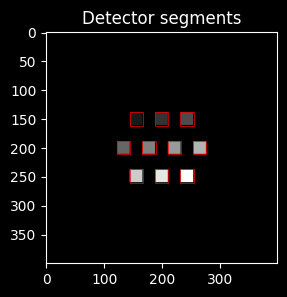

In [51]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

### 2.3.3. Train and Test datasets of wavefronts sequences

In [52]:
AUGMENTATION_FLIP = VARIABLES['augmentation_flip']  # if True uses a horisotal flip to make dataset twice as large

In [53]:
AUGMENTATION_FLIP

True

In [54]:
train_seqs_ds = WeizmannDsWfSeqs(
    all_train_files,
    transforms_for_ds,
    SIM_PARAMS,
    augmentation_horizontally_flip=AUGMENTATION_FLIP,
    target='detector',
    detector_mask=DETECTOR_MASK,
)  # item: (image wavefront, target detector tensor, label)

test_seqs_ds = WeizmannDsWfSeqs(
    all_test_files,
    transforms_for_ds,
    SIM_PARAMS,
    augmentation_horizontally_flip=AUGMENTATION_FLIP,
    target='detector',
    detector_mask=DETECTOR_MASK,
)  # item: (image wavefront, target detector tensor, label)

In [55]:
print(f'Train dataset of sequences: {len(train_seqs_ds)}')
print(f'Test  dataset of sequences: {len(test_seqs_ds)}')

Train dataset of sequences: 6896
Test  dataset of sequences: 3064


#### Classes disbalance

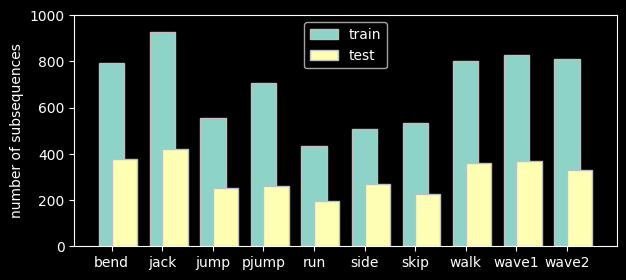

In [56]:
train_list = [ACTION_TO_ID[key] for key, val in train_seqs_ds.seqs_counter.items() for _ in range(val)]
test_list = [ACTION_TO_ID[key] for key, val in test_seqs_ds.seqs_counter.items() for _ in range(val)]


fig, ax0 = plt.subplots(1, 1, figsize=(7, 3))
bars_width = 0.5
bars_shift = 0.25

ax0.hist(
    train_list, bins=list(range(NUM_ACTIONS + 1)),
    align='left', rwidth=bars_width, label='train',
    edgecolor='silver'
)
ax0.hist(
    np.array(test_list) + bars_shift, bins=np.arange(NUM_ACTIONS + 1) + bars_shift,
    align='left', rwidth=bars_width, label='test',
    edgecolor='silver'
)

ax0.set_xticks(range(NUM_ACTIONS))
ax0.set_xticklabels([ID_TO_ACTION[ind] for ind in range(NUM_ACTIONS)])

ax0.set_ylabel('number of subsequences')
ax0.set_ylim([0, 1000])

ax0.legend()
plt.show()

#### Weights of classes (based on train dataset)

In [57]:
if VARIABLES['weighted_detector_zones']:
    max_class_size = max(train_seqs_ds.seqs_counter.values())
    
    weights_dict = {
        key: max_class_size / value 
        for key, value in train_seqs_ds.seqs_counter.items()
    }

    WEIGHTS_DETECTOR = [weights_dict[ID_TO_ACTION[i]] for i in range(NUM_ACTIONS)]
    WEIGHTS_DETECTOR = torch.tensor(WEIGHTS_DETECTOR).unsqueeze(0)

In [58]:
if VARIABLES['weighted_detector_zones']:
    for key, val in weights_dict.items():
        print(f'{key}\t:\t{val}')
        
    # detector weights mask
    DETECTOR_WEIGHTS_MASK = torch.zeros(
        size=SIM_PARAMS.axes_size(axs=('W', 'H'))
    )
    for act in ACTIONS:
        id_act = ACTION_TO_ID[act]
        DETECTOR_WEIGHTS_MASK += torch.where(DETECTOR_MASK == id_act, weights_dict[act], 0.0)
    DETECTOR_WEIGHTS_MASK += torch.where(DETECTOR_MASK == -1, 1.0, 0.0)

bend	:	1.1717171717171717
jack	:	1.0
jump	:	1.669064748201439
pjump	:	1.3144475920679888
run	:	2.1481481481481484
side	:	1.8339920948616601
skip	:	1.7378277153558053
walk	:	1.1571072319201996
wave1	:	1.1180722891566266
wave2	:	1.145679012345679


### 2.3.4. Examples of sequences from Train dataset

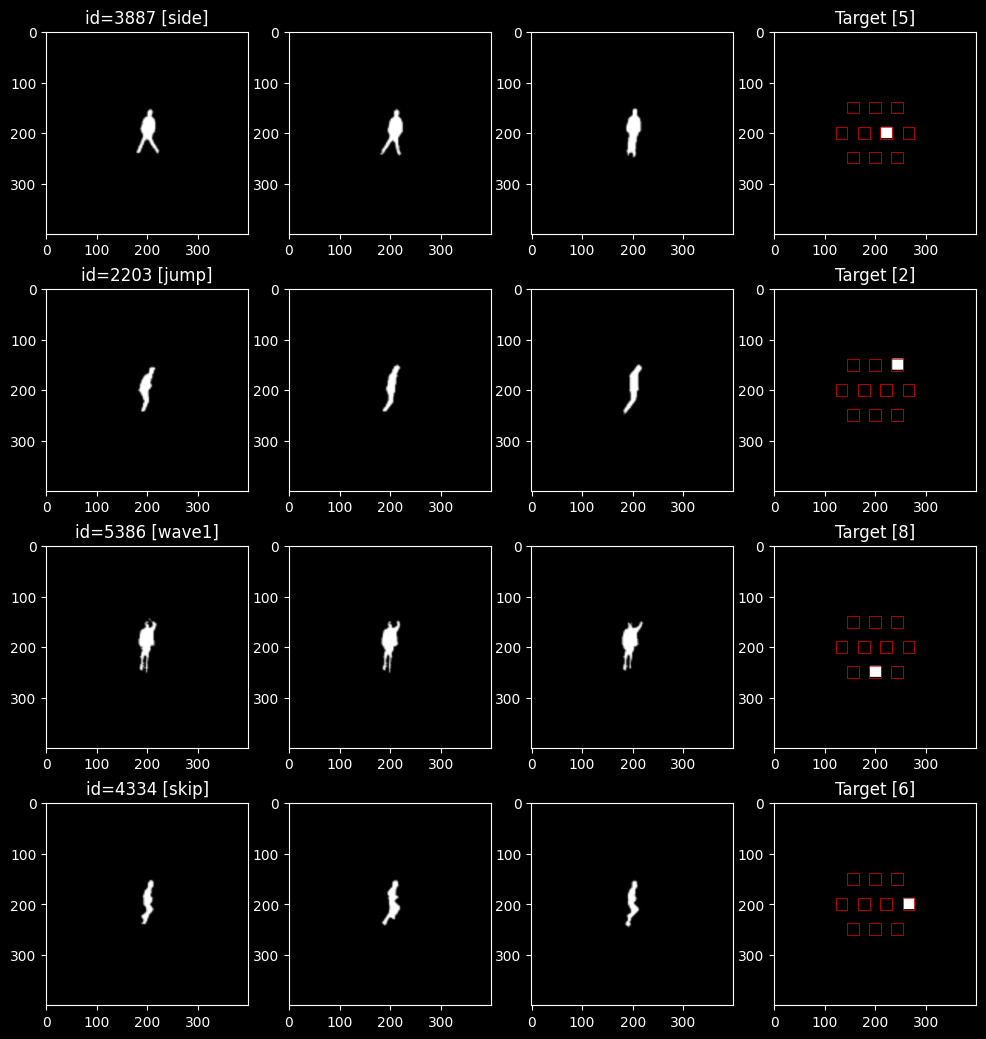

In [59]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(12)
train_examples_ids = random.sample(range(len(train_seqs_ds)), n_examples)

n_cols = NETWORK_SEQ + 1  # number of columns to plot masks (last column for targets)
to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'

fig, axs = plt.subplots(n_examples, n_cols, figsize=(n_cols * 3, n_examples * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    sequence, target, label = train_seqs_ds[ind_train]
    # print(sequence.shape)
    
    for frame_ind in range(NETWORK_SEQ):
        frame_this_wf = sequence[frame_ind]
        # print(f'Example #{ind_ex}, frame #{frame_ind + 1}: {frame_this_wf.shape}')
        
        assert isinstance(frame_this_wf, Wavefront)
        
        if frame_ind == 0:
            axs[ind_ex][frame_ind].set_title(f'id={ind_train} [{ID_TO_ACTION[label]}]')

        if to_plot == 'amp':
            axs[ind_ex][frame_ind].imshow(
                frame_this_wf.intensity, cmap=cmap,
                vmin=0, vmax=1, 
            )
        else: 
            axs[ind_ex][frame_ind].imshow(frame_this_wf.phase, cmap=cmap)

    axs[ind_ex][frame_ind + 1].set_title(f'Target [{label}]')
    axs[ind_ex][frame_ind + 1].imshow(target, cmap=cmap)
    
    for zone in get_zones_patches(DETECTOR_MASK):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[ind_ex][frame_ind + 1].add_patch(zone)
    
plt.show()

# 3. Recurrent Optical Network

<div>
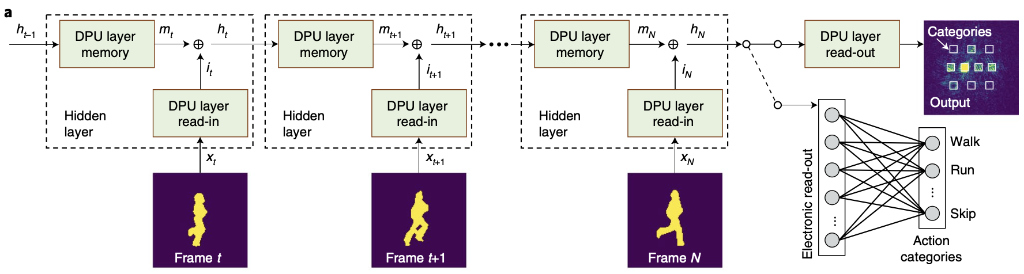
</div>

Fig. 4(a) from [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4).

> For the D-RNN hidden layer at the time step of $t$, the hidden state ht is a function of the hidden state ht−1 at the time step of $t−1$ and of the input sequence $x_t$ at the time step of $t$. We
adopt an affine combination to fuse the states from these two sources, that is, $h_t=\lambda f_1(h_{t-1})+(1-\lambda)f_2(x_t)$, where $m_t=f_1(h_{t-1})$ denotes the memory state mapping from $h_{t-1}$; $i_t=f_2(x_t)$ denotes the input state mapping from $x_t$; and $\lambda\in(0,1)$ is the fusing coefficient that controls the strength of the memory state with respect to the input state.

## 3.1. Reproducing of a network architecture

### 3.1.1. Some constatns

In [60]:
FUSING_COEFF = VARIABLES['fusing_coefficient']  # the best value according to the article [1] results

In [61]:
MAX_PHASE = VARIABLES['max_phase']  # maximal phase for diffractive layers
INIT_PHASE = VARIABLES['init_phase']  # initial phase for Diffractive layers

In [62]:
FS_METHOD = VARIABLES['free_space_method']
DISTANCE = VARIABLES['free_space_distance']  # [m]

### 3.1.2. Functions to get new elements

In [63]:
from src_weizmann.get_elements import get_free_space, get_const_phase_layer, get_nonlinear_layer

In [64]:
if APERTURES:
    # equal masks for all apertures (select a part in the middle)
    APERTURE_MASK = torch.ones(size=DETECTOR_SIZE)

    y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
    y_mask, x_mask = APERTURE_MASK.size()
    pad_top = int((y_nodes - y_mask) / 2)
    pad_bottom = y_nodes - pad_top - y_mask
    pad_left = int((x_nodes - x_mask) / 2)
    pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
    
    # padding transform to match aperture size with simulation parameters     
    APERTURE_MASK = functional.pad(
        input=APERTURE_MASK,
        pad=(pad_left, pad_right, pad_top, pad_bottom),
        mode='constant',
        value=0
    )

### 3.1.3. Model class

In [65]:
READ_IN_NONLIN, MEMORY_NONLIN, READ_OUT_NONLIN = VARIABLES['use_nonlinear_layers']

In [66]:
VARIABLES['read_in_freespace']

True

### Optical RNN class

In [67]:
import src_weizmann.drnn
from src_weizmann.drnn import DiffractiveRNN

# transfer all constant to module
src_weizmann.drnn.VARIABLES = VARIABLES

src_weizmann.drnn.READ_IN_NONLIN = READ_IN_NONLIN
src_weizmann.drnn.MEMORY_NONLIN = MEMORY_NONLIN
src_weizmann.drnn.READ_OUT_NONLIN = READ_OUT_NONLIN

src_weizmann.drnn.DISTANCE = DISTANCE

src_weizmann.drnn.APERTURES = APERTURES
src_weizmann.drnn.APERTURE_MASK = APERTURE_MASK

src_weizmann.drnn.MAX_PHASE = MAX_PHASE
src_weizmann.drnn.INIT_PHASE = INIT_PHASE

### Load model weights

In [68]:
def get_rnn():
    return DiffractiveRNN(
        sequence_size=NETWORK_SEQ,
        fusing_coeff=FUSING_COEFF,
        sim_params=SIM_PARAMS,
        fs_method=FS_METHOD,
    )

In [69]:
load_model_filepath = f'{RESULTS_FOLDER}/recurrent_net.pth'

loaded_rnn = get_rnn()
loaded_rnn.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_38681/3996458311.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_rnn.load_state_dict(torch.load(load_mo

<All keys matched successfully>

### 3.1.4 Detector processor (to calculate accuracies only)

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [79]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies']  # if False, accuracies will not be calculated!

if VARIABLES['loss'] == 'CE':
    CALCULATE_ACCURACIES = True  # always True for CrossEntropyLoss!

In [80]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    if VARIABLES['weighted_detector_zones']:
        detector_processor = DetectorProcessorClf(
            simulation_parameters=SIM_PARAMS,
            num_classes=NUM_ACTIONS,
            segmented_detector=DETECTOR_MASK,
            segments_weights=WEIGHTS_DETECTOR,  # <- weights for zones integral!
        )
    else:
        detector_processor = DetectorProcessorClf(
            simulation_parameters=SIM_PARAMS,
            num_classes=NUM_ACTIONS,
            segmented_detector=DETECTOR_MASK,
        )
else:
    detector_processor = None

# 4. Loading and testing of the network

## 4.1. Necessary tools

In [81]:
DEVICE = VARIABLES['DEVICE']  # 'mps' is not support a CrossEntropyLoss

In [82]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

### 4.1.1. `DataLoader`'s

In [83]:
train_bs = VARIABLES['train_batch_size']  # a batch size for training set
val_bs = VARIABLES['val_batch_size']

In [84]:
train_wf_loader = torch.utils.data.DataLoader(
    train_seqs_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    test_seqs_ds,
    batch_size=val_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

In [85]:
LR = VARIABLES['adam_lr']

In [86]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [87]:
LOSS = VARIABLES['loss']

In [88]:
if LOSS == 'MSE':
    loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
    loss_func_name = 'MSE'

if LOSS == 'CE':
    loss_func_clf = nn.CrossEntropyLoss()
    loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [89]:
import src_weizmann.loops
# from src_weizmann.loops import rnn_train  # we do not need trai loop in that notebook!
from src_weizmann.loops import rnn_validate

# transfer all constant to module
src_weizmann.loops.CALCULATE_ACCURACIES = CALCULATE_ACCURACIES
src_weizmann.loops.LOSS = LOSS

## 4.2. Model testing

### 4.2.1. Metrics

#### Learning curves (Loss and Accuracy)

In [90]:
losses_data = np.genfromtxt(
    f'{RESULTS_FOLDER}/training_curves.csv',
    delimiter=','
)

In [91]:
n_epochs = VARIABLES['number_of_epochs']
(train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc) = losses_data[1:, :].T

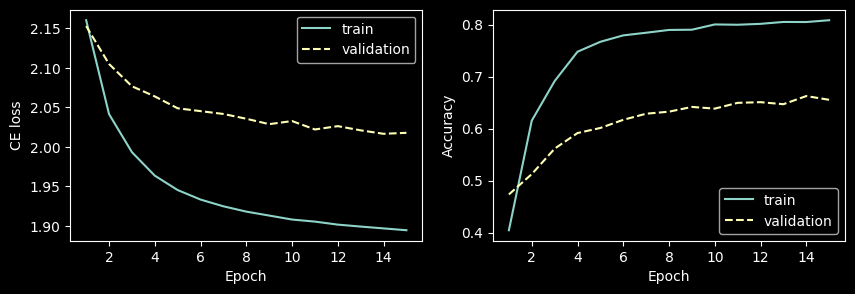

In [92]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses), label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

#### Metrics for test dataset

In [93]:
# Comment: not tested for `cuda`!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
loaded_rnn = loaded_rnn.to(DEVICE)

if detector_processor:
    detector_processor = detector_processor.to(DEVICE)

In [94]:
test_losses_0, _, test_accuracy_0 = rnn_validate(
    loaded_rnn,  # optical recurrent network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results of the loaded D-RNN on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|██████████████████████████████████████████| 154/154 [05:40<00:00,  2.21s/it]

Results of the loaded D-RNN on TEST set:
	CE loss : 2.017479
	Accuracy : 65.5 %


#### Metrics for train dataset

In [95]:
test_losses_1, _, test_accuracy_1 = rnn_validate(
    loaded_rnn,  # optical recurrent network composed in 3.
    train_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results of the loaded D-RNN on TRAIN set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1*100):>0.1f} %'
)

validation: 100%|██████████████████████████████████████████| 690/690 [12:57<00:00,  1.13s/it]

Results of the loaded D-RNN on TRAIN set:
	CE loss : 1.888993
	Accuracy : 80.8 %


### 4.2.2. Trained masks

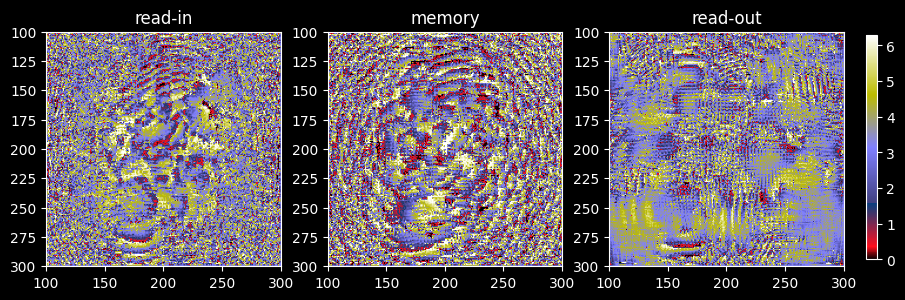

In [96]:
n_cols = 3  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_module, module in enumerate(
    [loaded_rnn.read_in_layer, loaded_rnn.memory_layer, loaded_rnn.read_out_layer]
):
    titles = ['read-in', 'memory', 'read-out']
    
    for ind_layer, layer in enumerate(module):
        if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
            if n_rows > 1:
                ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
            else:
                ax_this = axs[ind_diff_layer % n_cols]
    
            ax_this.set_title(titles[ind_module])
    
            trained_mask = layer.mask.detach()
            
            phase_mask_this = ax_this.imshow(         
                trained_mask, cmap=cmap,
                vmin=0, vmax=MAX_PHASE
            )
            ind_diff_layer += 1
    
            if APERTURES:  # select only a part within apertures!
                x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
                y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
                ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

## 4.3. Predicting video class by averaging predictions for all sub-sequences

### 4.3.1. Function that splits a video into sub-sequences and returns predictions

In [97]:
def predict_video(net, masks_filepath, flip=True, show_process=True):

    action_name = masks_filepath.split('/')[2].split('_')[0]  # depends on a data directory!
    label = ACTION_TO_ID[action_name]  # label for the sequence
    
    file_seqs_ds = WeizmannDsWfSeqs(
        [masks_filepath],
        transforms_for_ds,
        SIM_PARAMS,
        augmentation_horizontally_flip=flip,
        target='detector',
        detector_mask=DETECTOR_MASK,
    )  # item: (image wavefront, target detector tensor, label)

    # sum of all detector images for each sequence of the video
    detector_image = torch.zeros(
        size = SIM_PARAMS.axes_size(
            axs=('H', 'W')
        )
    )
    seqs_pred_labels = []

    if flip:# sum of all detector images for each flipped squence of the video
        flipped_detector_image = torch.zeros(
            size = SIM_PARAMS.axes_size(
                axs=('H', 'W')
            )
        )
        flipped_seqs_pred_labels = []

    ind_this = 0
    for seq_wavefronts, seq_target, seq_label in tqdm(file_seqs_ds, disable=not show_process):
        
        net.eval()  # pedict sequence:
        with torch.no_grad():
            seq_detector = net(seq_wavefronts)
            if flip:
                if ind_this % 2 == 0:  # not flipped sequence
                    detector_image += seq_detector
                else:  # flipped sequence
                    flipped_detector_image += seq_detector
            else:
                detector_image += seq_detector
    
            # process a detector image
            if detector_processor:
                pred_label_this = detector_processor.forward(detector_image).argmax().item()  # predicted label
                
                if flip:
                    if ind_this % 2 == 0:  # not flipped sequence
                        seqs_pred_labels.append(pred_label_this)
                    else:  # flipped sequence
                        flipped_seqs_pred_labels.append(pred_label_this)
                else:
                    seqs_pred_labels.append(pred_label_this)

        ind_this +=1
    if flip:
        return detector_image + flipped_detector_image, seqs_pred_labels, flipped_seqs_pred_labels, label
    else:
        return detector_image, seqs_pred_labels, label

### 4.3.2. Example of predicting one file

In [98]:
test_filepath = all_test_files[22]  # select any filepath from test set
test_filename = test_filepath.split('/')[-1]

use_flipped_seqs = True  # using horizontal flip to predict file or not

print(test_filename)

ira_walk.npy


In [99]:
# predicting a file by all subsequences
detector_sum, labels_by_seqs, labels_by_flipped_seqs, label_0 = predict_video(
    loaded_rnn, test_filepath, flip=use_flipped_seqs
)

100%|██████████████████████████████████████████████████████| 162/162 [00:26<00:00,  6.03it/s]


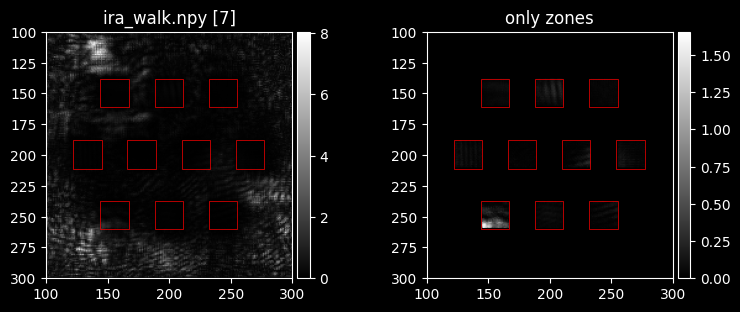

In [100]:
# plot detector images sum for a video
fig, axs = plt.subplots(1, 2, figsize=(3 * 3, 3.2))
cmap = 'grey'

ax_this = axs[0]
ax_this.set_title(f'{test_filename} [{label_0}]')
img = ax_this.imshow(detector_sum, cmap=cmap)
# colorbar
divider = make_axes_locatable(ax_this)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')


ax_this = axs[1]
ax_this.set_title('only zones')
detector_zones_selection_mask = torch.where(DETECTOR_MASK > -1, 1.0, 0.0)
img = ax_this.imshow(detector_sum * detector_zones_selection_mask, cmap=cmap)
# colorbar
divider = make_axes_locatable(ax_this)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')

for ax_this in axs:
    for zone in get_zones_patches(DETECTOR_MASK):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    if APERTURES:  # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])
    
plt.show()

In [101]:
if detector_processor:
    for label, proba in enumerate(detector_processor.forward(detector_sum)[0]):
        print(f'{ID_TO_ACTION[label]}:\t{proba * 100:.2f}%')

bend:	6.38%
jack:	11.11%
jump:	6.11%
pjump:	8.10%
run:	3.95%
side:	9.79%
skip:	9.91%
walk:	33.74%
wave1:	5.70%
wave2:	5.22%


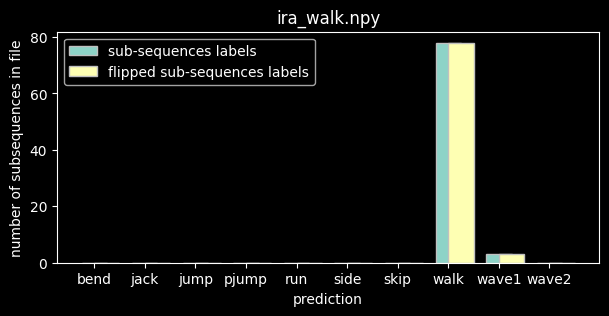

In [102]:
fig, ax0 = plt.subplots(1, 1, figsize=(7, 3))
bars_width = 0.5
bars_shift = 0.25

ax0.hist(
    labels_by_seqs, bins=list(range(NUM_ACTIONS + 1)),
    align='left', rwidth=bars_width, label='sub-sequences labels',
    edgecolor='silver'
)

ax0.hist(
    np.array(labels_by_flipped_seqs) + bars_shift, 
    bins=np.arange(NUM_ACTIONS + 1) + bars_shift,
    align='left', rwidth=bars_width, label='flipped sub-sequences labels',
    edgecolor='silver'
)

# axes settings
ax0.set_title(test_filepath.split('/')[-1])

ax0.set_xticks(range(NUM_ACTIONS))
ax0.set_xticklabels([ID_TO_ACTION[ind] for ind in range(NUM_ACTIONS)])

ax0.set_ylabel('number of subsequences in file')
ax0.set_xlabel('prediction')

# ax0.set_ylim([0, 1000])

ax0.legend()
plt.show()

### 4.3.3. Prediction all test files

In [97]:
NUM_TEST_FILES = len(all_test_files)

In [98]:
# confusion matrix
# prediction by subsequences labels
confusion_matrix_top_seqs = torch.zeros(size=(len(all_test_files), NUM_ACTIONS), dtype=torch.int32)

# predictions by detector probas
confusion_matrix_detector = torch.zeros(size=(len(all_test_files), NUM_ACTIONS), dtype=torch.float32)

In [103]:
true_predictions = 0
false_predictions = 0

top_length = 3  # check top 3 predictions
in_top = 0

for ind_file, filepath in enumerate(tqdm(all_test_files)):
    detector_1, pred_labels_1, pred_labels_2, true_label = predict_video(
        loaded_rnn, filepath, flip=True, show_process=False
    )

    # ind_file must be connected with label!
    # all_test_files is sorted by actions!
    
    counter_preds = Counter(pred_labels_1 + pred_labels_2)
    # update confusion matrix
    confusion_matrix_top_seqs[ind_file, :] = torch.tensor([counter_preds[label] for label in range(NUM_ACTIONS)])
    
    # is the true prediction in top N?
    top_preds = counter_preds.most_common(top_length)
    for pred, _ in top_preds:
        if pred == true_label:
            in_top += 1
            break
    
    if detector_processor:
        probas = detector_processor.forward(
            detector_1
        )[0]
        predicted_label = probas.argmax().item()

    confusion_matrix_detector[ind_file, :] = probas  # update confusion matrix
    
    if predicted_label == true_label:
        true_predictions += 1
    else:
        false_predictions += 1

print(f'Files prediction accuracy: {true_predictions / (true_predictions + false_predictions) * 100 :.2f}%')
print(f'True label in top-{top_length} predictions for {in_top} out of {len(all_test_files)} test files')

100%|████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]

Files prediction accuracy: 86.67%
True label in top-3 predictions for 26 out of 30 test files
